# Simulation Environments

ARIEL provides several simulated environments for MuJoCo.
In this notebook we attempt to load and visualize them.
To make sure that the environments are working properly, and that they also look correct

In [1]:
# Standard library
import inspect

In [2]:
# Third-party imports
import mujoco
import numpy as np
from matplotlib import pyplot as plt
from rich.console import Console
from rich.table import Table

%matplotlib inline
console = Console()

In [3]:
# Ariel imports
from ariel.simulation import environments as envs
from ariel.simulation.environments import BaseWorld, SimpleFlatWorld
from ariel.utils.renderers import single_frame_renderer

In [4]:
# Display available environments
num_of_envs = len(inspect.getmembers(envs, inspect.isclass))
table = Table(title=f"ARIEL-MuJoCo Environments (total: {num_of_envs})")
table.add_column("Name", justify="center", style="cyan bold", no_wrap=True)

for name, _ in inspect.getmembers(envs, inspect.isclass):
    table.add_row(name)

console.print(table)

 ARIEL-MuJoCo Environments  
         (total: 9)         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Name           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AmphitheatreTerrainWorld │
│        BaseWorld         │
│      CompoundWorld       │
│    CraterTerrainWorld    │
│       OlympicArena       │
│    RuggedTerrainWorld    │
│    RuggedTiltedWorld     │
│     SimpleFlatWorld      │
│    SimpleTiltedWorld     │
└──────────────────────────┘

## Worlds

ARIEL provides several prebuilt MuJoCo worlds.
In the code cells below we visualize them.

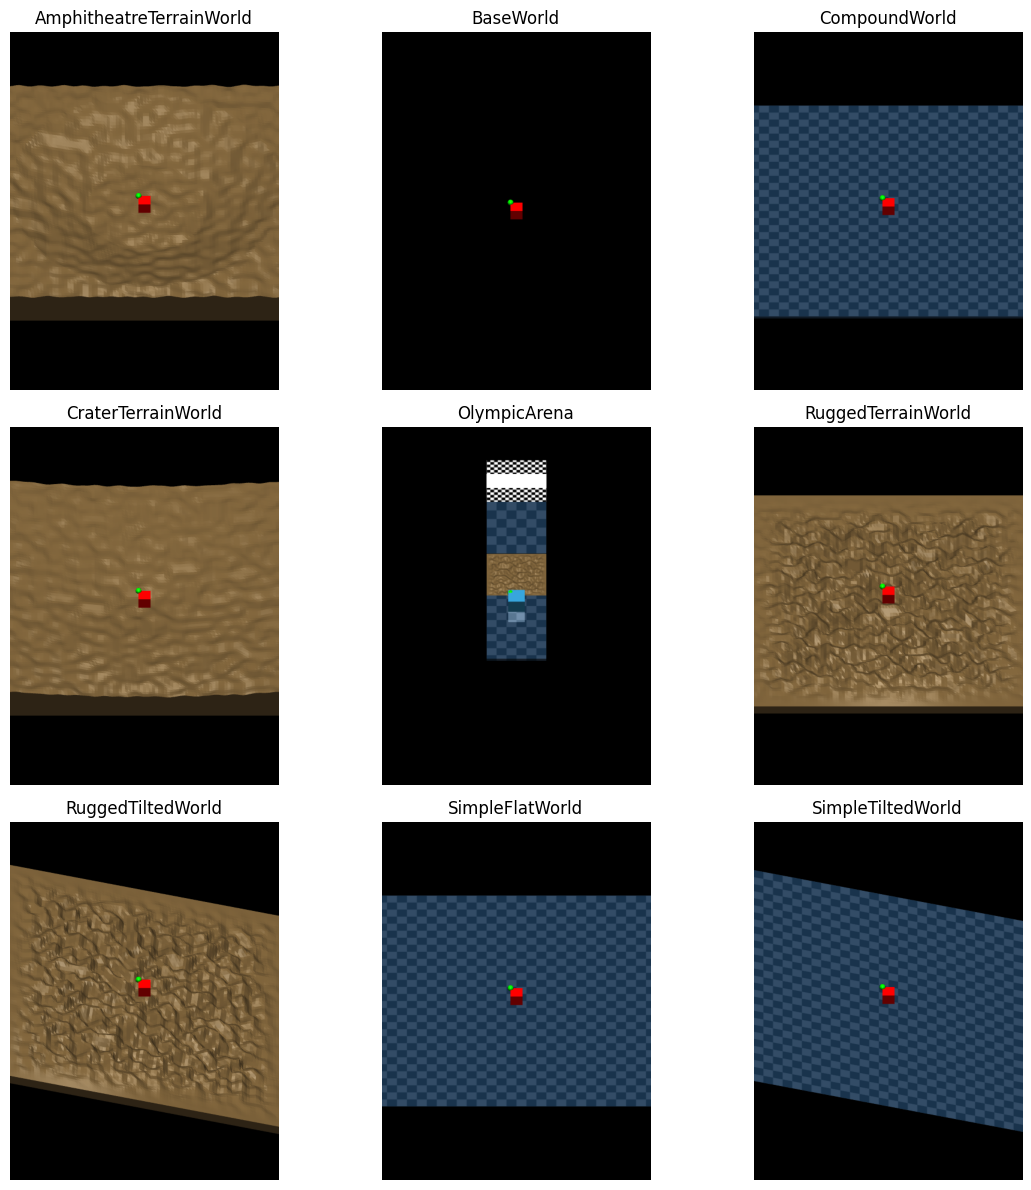

In [5]:
# Object to spawn in each environment
xml = r"""
<mujoco>
    <worldbody>
        <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name="green_box" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </worldbody>
</mujoco>
"""

# Generate a grid of noise
fig_size = int(np.ceil(num_of_envs / 3))
fig, axes = plt.subplots(fig_size, 3, figsize=(12, 12))
ax = axes.ravel()
ax_filled = np.zeros(len(ax))
for i, (name, cls) in enumerate(inspect.getmembers(envs, inspect.isclass)):
    # Instantiate the environment
    world = cls()

    # Spawn a test object to validate the environment
    test_object = mujoco.MjSpec.from_string(xml)
    world_spec = world.spawn(
        test_object,
        position=(0, 0, 0),
        rotation=(0, 0, 0),
        correct_spawn_for_collisions=True,
    )

    # Compile the model and create data
    model = world.spec.compile()
    data = mujoco.MjData(model)

    # Render a single frame
    img = single_frame_renderer(model, data, steps=1, fovy=12)
    im = ax[i].imshow(img, origin="upper")
    ax[i].set_title(name)
    ax[i].axis("off")
    ax_filled[i] = 1

    # Clear memory
    del world, model, data, test_object, img

# remove empty subplots
for ax_i, filled in enumerate(ax_filled):
    if filled == 0:
        fig.delaxes(ax[ax_i])

plt.tight_layout()
plt.show()

## Height Field Functions

ARIEL provides several height field functions to create terrains.
In this below cell we visualize them as z-height maps.

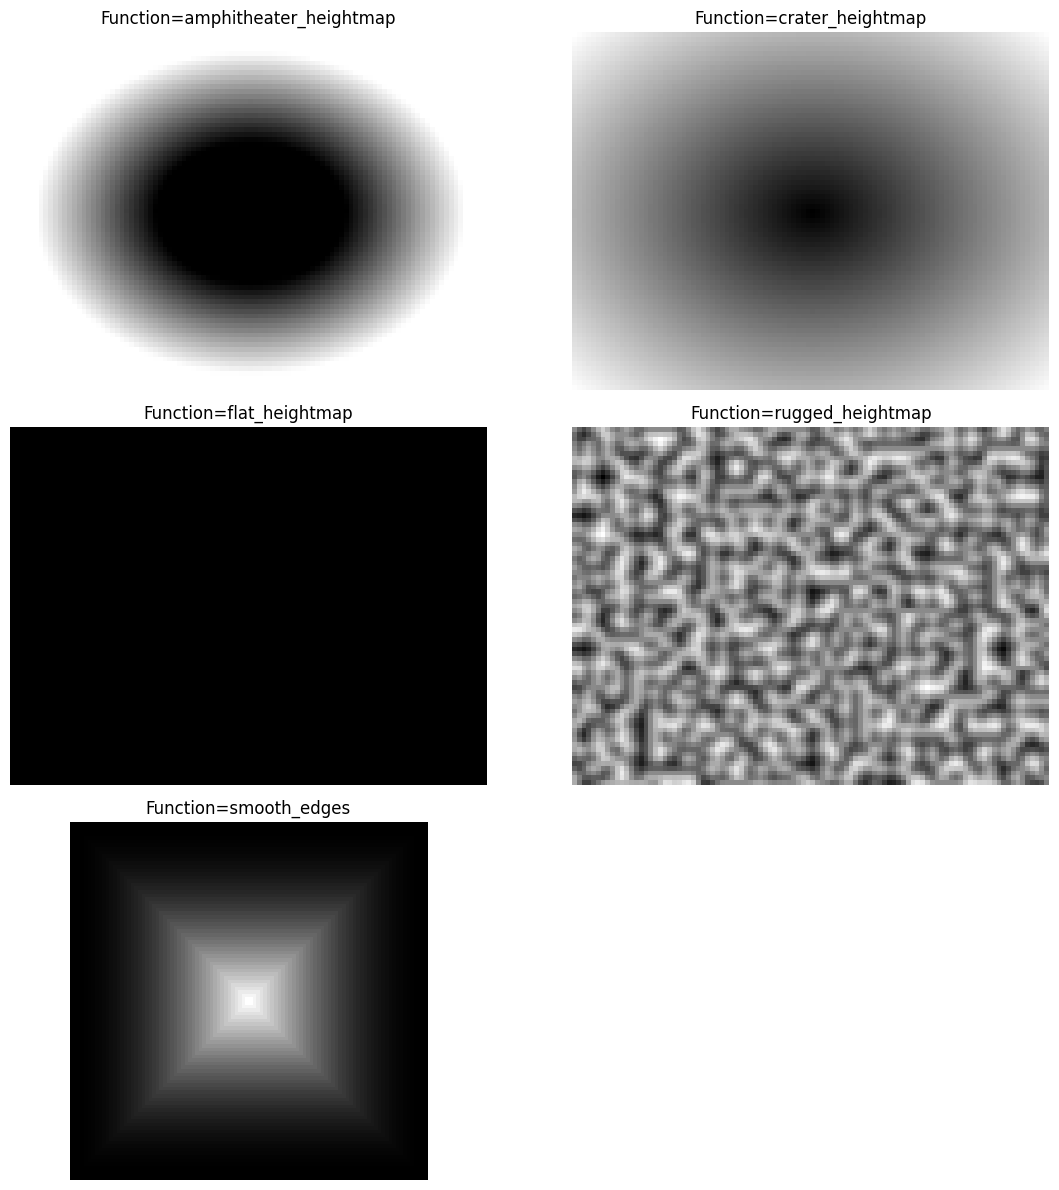

In [6]:
arguments = {
    "flat_heightmap": {
        "dims": (75, 100),
    },
    "rugged_heightmap": {
        "dims": (75, 100),
        "scale_of_noise": 4,
        "normalize": None,
    },
    "amphitheater_heightmap": {
        "dims": (75, 100),
        "ring_inner_radius": 0.2,
        "ring_outer_radius": 0.45,
        "cone_height": 1.0,
    },
    "crater_heightmap": {
        "dims": (75, 100),
        "crater_depth": 1.0,
        "crater_radius": 0.3,
    },
    "smooth_edges": {
        "dims": (100, 100),
        "edge_width": 25,
    },
}

functions = inspect.getmembers(
        envs.heightmap_functions,
        inspect.isfunction,
    )
cols = 2
num_of_functions = len(functions)
fig_size = int(np.ceil(num_of_functions / cols))
fig, axes = plt.subplots(fig_size, cols, figsize=(12, 12))
ax = axes.ravel()
ax_filled = np.zeros(len(ax))

# Loop through all functions in heightmap_functions.py
for i, (_, func) in enumerate(functions):
    # Call the function with default parameters
    grid = func(**arguments[func.__name__])
    im = ax[i].imshow(grid, cmap="gray", origin="upper")
    ax[i].set_title(f"Function={func.__name__}")
    ax[i].axis("off")
    ax_filled[i] = 1

# Remove empty subplots
for ax_i, filled in enumerate(ax_filled):
    if filled == 0:
        fig.delaxes(ax[ax_i])

plt.tight_layout()
plt.show()

## Spawning

ARIEL world classes provide a method to spawn objects in the environment.

The class method `spawn` is responsible for adding an object to the environment at a specified position and orientation.

This method also attempts to correct the spawn position of the object to avoid collisions with the environment.

In the code cell below we visualize this functionality.

### Sawn Collision (boolean)

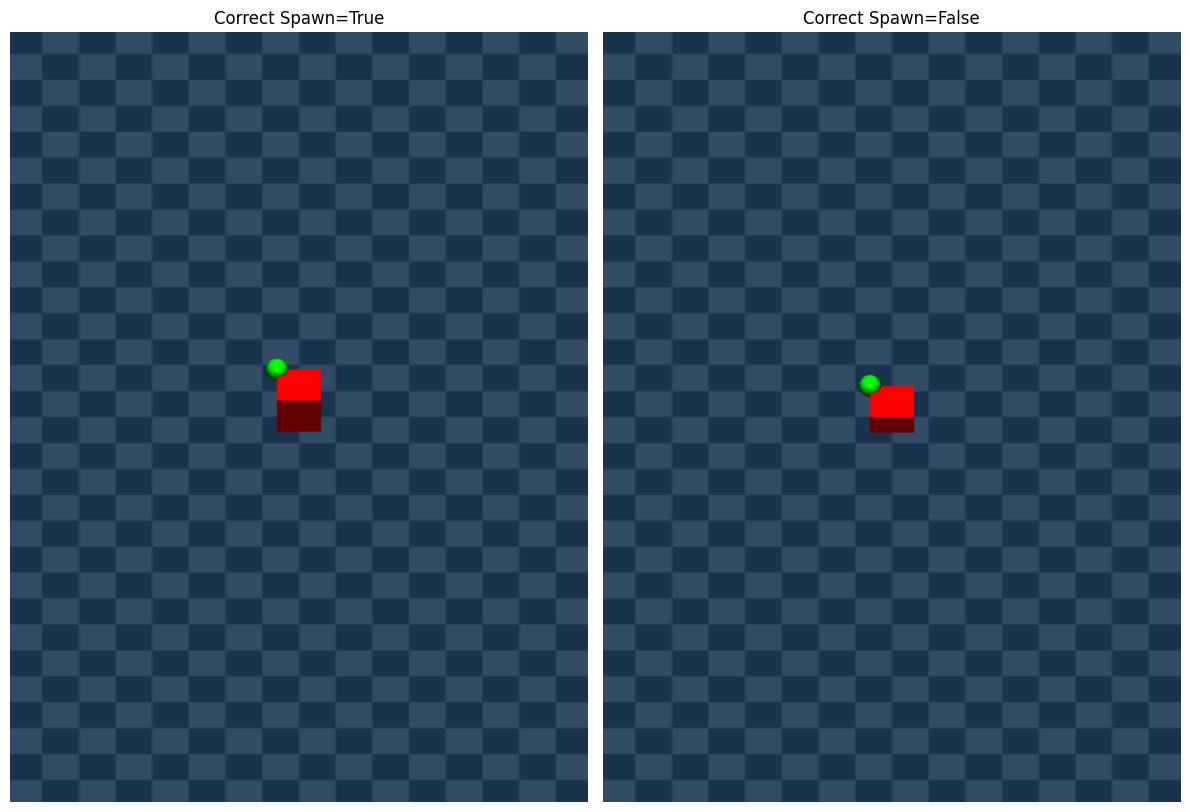

In [7]:
# Generate a grid of noise
spawn_modes = (True, False)
axis = (0, 0, 1, 2)  # x, x, y, z
num_of_modes = len(spawn_modes)
cols = 2
fig_size = int(np.ceil(num_of_modes / cols))
fig, axes = plt.subplots(fig_size, cols, figsize=(12, 12))
ax = axes.ravel()
ax_filled = np.zeros(len(ax))

for i, mode in enumerate(spawn_modes):
    xml = r"""
    <mujoco>
    <worldbody>
        <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </worldbody>
    </mujoco>
    """
    # Instantiate the environment
    world = SimpleFlatWorld()

    # Spawn a test object to validate the environment
    test_object = mujoco.MjSpec.from_string(xml)
    world_spec = world.spawn(
        test_object,
        position=(0, 0, 0),
        rotation=(0, 0, 0),
        correct_spawn_for_collisions=mode,
    )

    # Compile the model and create data
    model = world_spec.compile()
    data = mujoco.MjData(model)

    # Render a single frame
    img = single_frame_renderer(model, data, steps=1)
    im = ax[i].imshow(img, origin="upper")
    ax[i].set_title(f"Correct Spawn={mode}")
    ax[i].axis("off")
    ax_filled[i] = 1

    # Clear memory
    del world, model, data, test_object, img

# Remove empty subplots
for ax_i, filled in enumerate(ax_filled):
    if filled == 0:
        fig.delaxes(ax[ax_i])

plt.tight_layout()
plt.show()

### Rotation (tuple of 3 floats)

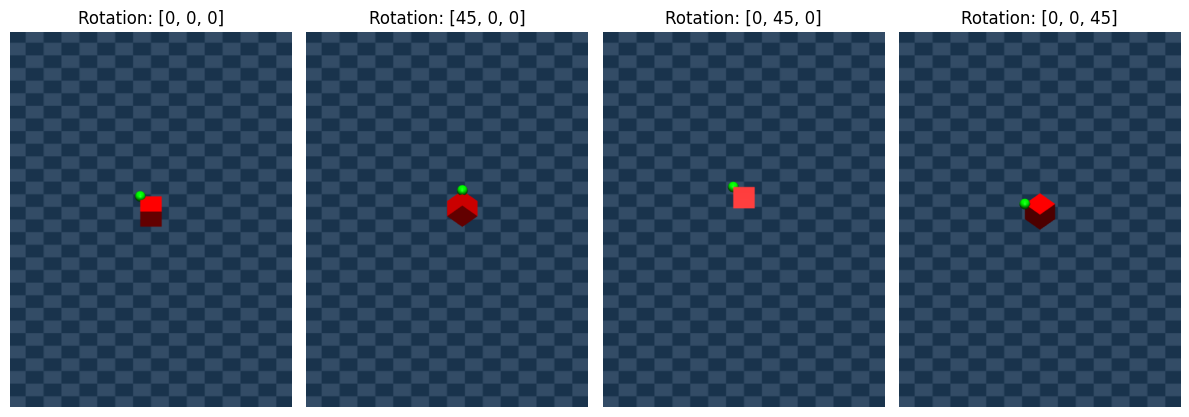

In [8]:
# Generate a grid of noise
angles = (0, 45, 45, 45)
axis = (0, 0, 1, 2)  # x, x, y, z
num_of_angles = len(angles)
cols = 4
fig_size = int(np.ceil(num_of_angles / cols))
fig, axes = plt.subplots(fig_size, cols, figsize=(12, 12))
ax = axes.ravel()
ax_filled = np.zeros(len(ax))

for i, angle in enumerate(angles):
    xml = r"""
    <mujoco>
    <worldbody>
        <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </worldbody>
    </mujoco>
    """
    # Instantiate the environment
    world = SimpleFlatWorld()

    # Spawn a test object to validate the environment
    test_object = mujoco.MjSpec.from_string(xml)
    rotation = [0, 0, 0]
    rotation[axis[i]] = angle
    world_spec = world.spawn(
        test_object,
        position=(0, 0, 0),
        rotation=rotation,
        correct_spawn_for_collisions=True,
    )

    # Compile the model and create data
    model = world_spec.compile()
    data = mujoco.MjData(model)

    # Render a single frame
    img = single_frame_renderer(model, data, steps=1)
    im = ax[i].imshow(img, origin="upper")
    ax[i].set_title(f"Rotation: {rotation}")
    ax[i].axis("off")
    ax_filled[i] = 1

    # Clear memory
    del world, model, data, test_object, img

# Remove empty subplots
for ax_i, filled in enumerate(ax_filled):
    if filled == 0:
        fig.delaxes(ax[ax_i])

plt.tight_layout()
plt.show()

### Position (tuple of 3 floats)

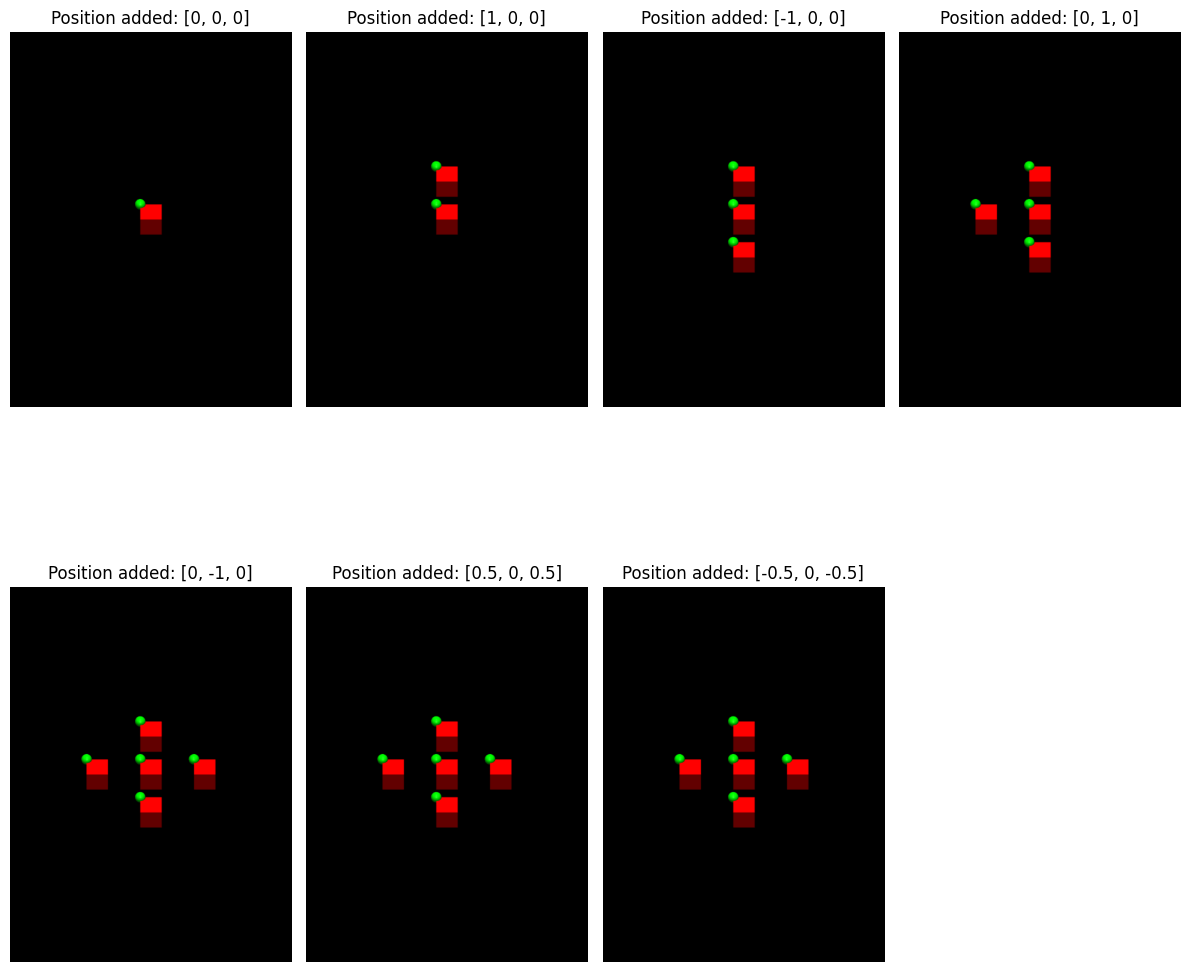

In [9]:
# Instantiate the environment
world = BaseWorld()

# Object description
xml = r"""
<mujoco>
<worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
</worldbody>
</mujoco>
"""

# Spawn positions
positions = [
    [0, 0, 0],
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0.5, 0, 0.5],
    [-0.5, 0, -0.5],
]

# Generate a grid of noise
num_of_positions = len(positions)
cols = 4
fig_size = int(np.ceil(num_of_positions / cols))
fig, axes = plt.subplots(fig_size, cols, figsize=(12, 12))
ax = axes.ravel()

# Spawn objects at all positions
ax_filled = np.zeros(len(ax))
for i, position in enumerate(positions):
    # Spawn a test object to validate the environment
    test_object = mujoco.MjSpec.from_string(xml)
    world_spec = world.spawn(
        test_object,
        position=position,
        rotation=(0, 0, 0),
        correct_spawn_for_collisions=False,
    )

    # Compile the model and create data
    model = world_spec.compile()
    data = mujoco.MjData(model)

    # Render a single frame
    img = single_frame_renderer(model, data, steps=1)
    im = ax[i].imshow(img, origin="upper")
    ax[i].set_title(f"Position added: {position}")
    ax[i].axis("off")
    ax_filled[i] = 1

    # Clear memory
    del model, data, test_object, img

# Remove empty subplots
for ax_i, filled in enumerate(ax_filled):
    if filled == 0:
        fig.delaxes(ax[ax_i])

plt.tight_layout()
plt.show()